# Proyecto de Cátedra – Machine Learning Supervisado
## Predicción de Deserción Estudiantil Universitaria mediante Modelos de Machine Learning Supervisado

**Dataset:** `Tbl_DesercionEstudiantil.csv`

---

## Integrantes

| Apellidos               | Nombres             | Número de carné |
|------------------------|--------------------|-----------------|
| Arévalo Alvarado       | Raúl Aníbal        | AA252630        |
| Cartagena Candelario   | Emerson Francisco  | CC100308        |
| Olmedo López           | Edwin Josué        | OL150100        |
| Rivas Araniva          | Diego Alfonso      | RA162519        |

## 1. Introducción y descripción del problema

### Contexto
Una institución educativa busca **identificar de manera proactiva a los estudiantes con alto riesgo de deserción** para poder ofrecer intervenciones oportunas y efectivas, como acompañamiento académico, becas, o tutorías personalizadas.

### Problema de Negocio
- **Tipo de Problema:** Clasificación Binaria Supervisada.
- **Variable Objetivo:** `Deserto`. Un valor de `1` indica que el estudiante desertó, mientras que `0` indica que continuó sus estudios.
- **Objetivo del Modelo:** Estimar la probabilidad de que un estudiante deserte en el próximo ciclo académico, basándose en su información académica y administrativa histórica.

### Valor para la Organización
- **Optimización de Recursos:** Permite a la institución priorizar y enfocar sus esfuerzos de retención en los estudiantes que más lo necesitan.
- **Reducción de Costos:** Disminuye los costos asociados a la pérdida de estudiantes y a la captación de nuevos alumnos.
- **Inteligencia de Negocio:** Facilita el monitoreo de indicadores de riesgo clave, permitiendo análisis por carrera, campus o período académico.

### Supuestos Clave
- El dataset contiene registros por estudiante y por ciclo académico, lo que significa que un mismo estudiante podría aparecer más de una vez si se analiza a lo largo de varios ciclos.

## 2. Carga y exploración inicial de datos

In [1]:
# 2.1 Importar librerías
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl 
import joblib

# Componentes de Scikit-Learn para preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Métricas para evaluar el rendimiento de los modelos de clasificación
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay,
    average_precision_score, PrecisionRecallDisplay
)

# Algoritmos de Machine Learning a evaluar

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb  # Se utiliza como modelo final

# Configuraciones de Pandas para una mejor visualización de los dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Configuraciones de Pandas para una mejor visualización de los dataframes

In [2]:
# Se define la ruta del archivo y se carga en un DataFrame de Pandas.
DATA_PATH = "Tbl_DesercionEstudiantil_PrimerAnio_.csv"
df = pd.read_csv(DATA_PATH)

# Se define una constante para el tamaño máximo de la muestra.
MAX_SAMPLES = 10000

# Para asegurar la reproducibilidad y eficiencia, se realiza un muestreo estratificado si el dataset es muy grande.
# Esto mantiene la proporción original de la variable objetivo.
# Nota: En este caso, el dataset es menor a 10,000 filas, por lo que este bloque no se ejecuta.
if len(df) > MAX_SAMPLES:
    df = df.groupby("Deserto", group_keys=False).apply(
        lambda x: x.sample(
            n=int(MAX_SAMPLES * len(x) / len(df)),
            random_state=42
        )
    )
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dimensiones del dataset: (7516, 25)


,Carrera,Plan,IdCampus,Sexo,AnioIngreso,CicloIngreso,InstitucionBach,TieneBeca,PorcentajeBeca_Promedio,MateriasInscritas_C1,MateriasAprobadas_C1,MateriasReprobadas_C1,TasaAprobacion_C1,PromedioCiclo_C1,MateriasInscritas_C2,MateriasAprobadas_C2,MateriasReprobadas_C2,TasaAprobacion_C2,PromedioCiclo_C2,TotalMateriasInscritas_Anio1,TotalMateriasAprobadas_Anio1,TotalMateriasReprobadas_Anio1,TasaAprobacion_Anio1,PromedioGeneral_Anio1,Deserto
0,409,2019,1,102301,2020,1,185,0,NaN,4,4,0,1.00,7.34,4,4,0,1.0,7.64,8,8,0,1.000,7.49,0
1,413,2016,1,102302,2020,1,142,0,NaN,4,3,0,0.75,5.12,4,4,0,1.0,8.33,8,7,0,0.875,6.72,0
2,202,2016,1,102301,2020,1,241,0,NaN,5,5,0,1.00,8.33,5,5,0,1.0,8.68,10,10,0,1.000,8.51,0
3,209,2019,1,102302,2020,1,246,0,NaN,5,5,0,1.00,7.48,4,4,0,1.0,7.47,9,9,0,1.000,7.47,0
4,105,2017,1,102302,2020,1,309,0,NaN,4,2,2,0.50,5.90,2,1,1,0.5,5.85,6,3,3,0.500,5.87,0


In [3]:
# 2.3. Longitud del dataset
len(df)

7516

In [4]:
# 2.4. Tipos de datos y resumen general
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7516 entries, 0 to 7515
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Carrera                        7516 non-null   int64  
 1   Plan                           7516 non-null   int64  
 2   IdCampus                       7516 non-null   int64  
 3   Sexo                           7516 non-null   int64  
 4   AnioIngreso                    7516 non-null   int64  
 5   CicloIngreso                   7516 non-null   int64  
 6   InstitucionBach                7516 non-null   int64  
 7   TieneBeca                      7516 non-null   int64  
 8   PorcentajeBeca_Promedio        533 non-null    float64
 9   MateriasInscritas_C1           7516 non-null   int64  
 10  MateriasAprobadas_C1           7516 non-null   int64  
 11  MateriasReprobadas_C1          7516 non-null   int64  
 12  TasaAprobacion_C1              7516 non-null   f

In [5]:
# Limpieza y Preparación Inicial de los Datos

# Normaliza nombres de columnas (quita espacios extremos)
df.columns = [str(c).strip() for c in df.columns]

# Eliminación de registros duplicados para evitar redundancia en los datos.
df_before = df.shape[0]
df = df.drop_duplicates()
df_after = df.shape[0]
print(f"[LIMPIEZA] Duplicados eliminados: {df_before - df_after}")

# Limpieza de strings en columnas tipo object
obj_cols = df.select_dtypes(include=["object"]).columns
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

# Reemplazo de strings "vacíos" por NaN (para imputación correcta)
df.replace({"": np.nan, "NA": np.nan, "N/A": np.nan, "null": np.nan, "None": np.nan}, inplace=True)

[LIMPIEZA] Duplicados eliminados: 0


### Exploración de la Variable Objetivo 'Deserto'

Validamos que `Deserto` sea binaria y revisamos el balance de clases.

In [6]:
# Análisis de la variable objetivo "Deserto"
target_col = "Deserto"
print("Valores únicos en Deserto:", sorted(df[target_col].dropna().unique()))
df[target_col].value_counts(dropna=False)

Valores únicos en Deserto: [0, 1]


Deserto
0    6663
1     853
Name: count, dtype: int64

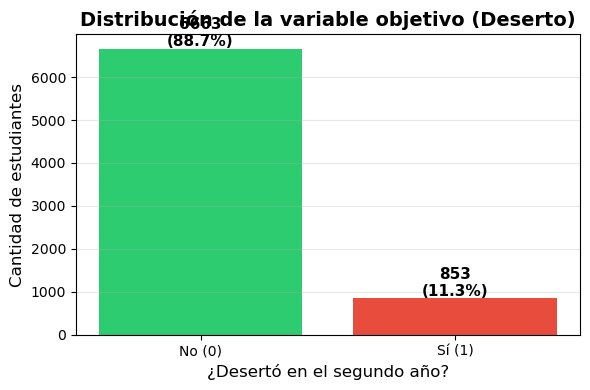


 Proporciones de clase:
Deserto
0    0.8865
1    0.1135
Name: count, dtype: float64


In [7]:
# Distribución (balance) de clases
counts = df[target_col].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values, color=['#2ecc71', '#e74c3c'])
plt.title("Distribución de la variable objetivo (Deserto)", fontsize=14, fontweight='bold')
plt.xlabel("¿Desertó en el segundo año?", fontsize=12)
plt.ylabel("Cantidad de estudiantes", fontsize=12)
plt.xticks(ticks=range(len(counts)), labels=['No (0)', 'Sí (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)

# Agregar etiquetas con porcentajes
for i, (idx, val) in enumerate(counts.items()):
    pct = 100 * val / counts.sum()
    plt.text(i, val + 50, f'{val}\n({pct:.1f}%)', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Proporciones de clase:")
proportions = (counts / counts.sum()).round(4)
print(proportions)

## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Preparación: identificar variables numéricas y categóricas

Como el dataset contiene **códigos** (por ejemplo `Carrera`, `Plan`, `InstitucionBach`), se separan columnas en:
- **Numéricas continuas / de conteo** (útiles para histogramas y correlación).
- **Categóricas codificadas** (útiles para conteos por categoría).


In [8]:

# Identificación de variables categóricas y numéricas
print("IDENTIFICACIÓN DE TIPOS DE VARIABLES")

# Heurística: columnas con baja cardinalidad suelen comportarse como categóricas (aunque sean int)
nunique = df.nunique()
low_cardinality_cols = nunique[nunique <= 30].index.tolist() # Se consideran categóricas aquellas con 30 o menos valores únicos.

# Objetivo no se considera feature
if target_col in low_cardinality_cols:
    low_cardinality_cols.remove(target_col)

# Candidate categóricas: baja cardinalidad + tipo int/obj
categorical_cols = [c for c in low_cardinality_cols if df[c].dtype == 'object' or df[c].dtype == 'int64']

# Se definen listas para forzar la clasificación de ciertas columnas, corrigiendo posibles detecciones erróneas.
forced_categorical = ["InstitucionBach", "Carrera", "Plan", "IdCampus", "Sexo"]
forced_numeric = ["MateriasInscritas_C1", "MateriasAprobadas_C1", "MateriasReprobadas_C1", "MateriasInscritas_C2", "MateriasAprobadas_C2", "MateriasReprobadas_C2", "TotalMateriasInscritas_Anio1", "TotalMateriasAprobadas_Anio1", "TotalMateriasReprobadas_Anio1"]

for col in forced_categorical:
    if col in df.columns and col not in categorical_cols:
        categorical_cols.append(col)

# Eliminar de categóricas si fueron forzadas a numéricas
for col in forced_numeric:
    if col in categorical_cols:
        categorical_cols.remove(col)

# Candidate numéricas: el resto (incluye float, conteos con alta cardinalidad)
numeric_cols = [c for c in df.columns if c not in categorical_cols + [target_col]]

for col in forced_numeric:
    if col in df.columns and col not in numeric_cols:
        numeric_cols.append(col)

print(f"\n Columnas categóricas detectadas ({len(categorical_cols)}):")
print(categorical_cols)
print(f"\n Columnas numéricas detectadas ({len(numeric_cols)}):")
print(numeric_cols)

IDENTIFICACIÓN DE TIPOS DE VARIABLES

 Columnas categóricas detectadas (8):
['Plan', 'IdCampus', 'Sexo', 'AnioIngreso', 'CicloIngreso', 'TieneBeca', 'InstitucionBach', 'Carrera']

 Columnas numéricas detectadas (16):
['PorcentajeBeca_Promedio', 'MateriasInscritas_C1', 'MateriasAprobadas_C1', 'MateriasReprobadas_C1', 'TasaAprobacion_C1', 'PromedioCiclo_C1', 'MateriasInscritas_C2', 'MateriasAprobadas_C2', 'MateriasReprobadas_C2', 'TasaAprobacion_C2', 'PromedioCiclo_C2', 'TotalMateriasInscritas_Anio1', 'TotalMateriasAprobadas_Anio1', 'TotalMateriasReprobadas_Anio1', 'TasaAprobacion_Anio1', 'PromedioGeneral_Anio1']


### 3.2 Análisis univariado

- Distribuciones de variables numéricas (histogramas).
- Outliers con boxplots (muestra rápida).
- Conteos para variables categóricas.


ANÁLISIS DE VARIABLES NUMÉRICAS


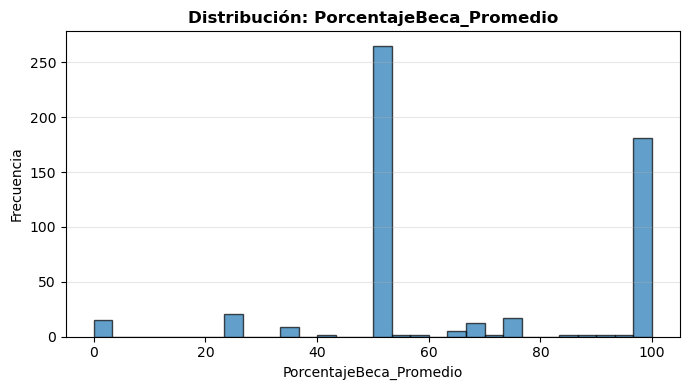

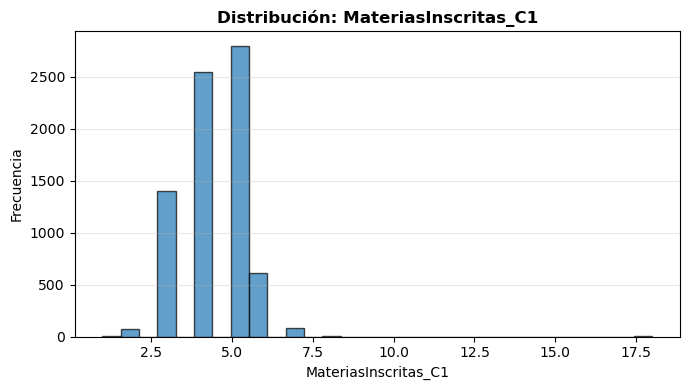

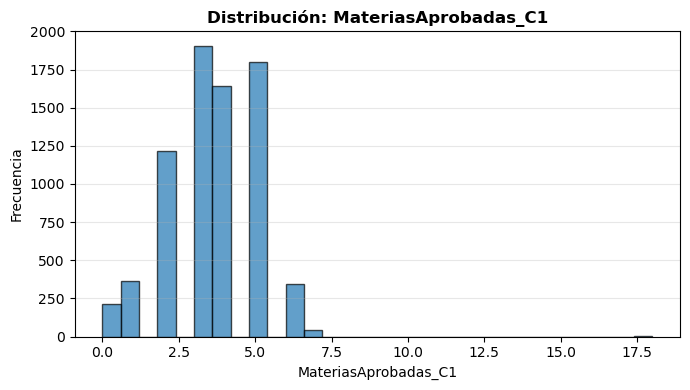

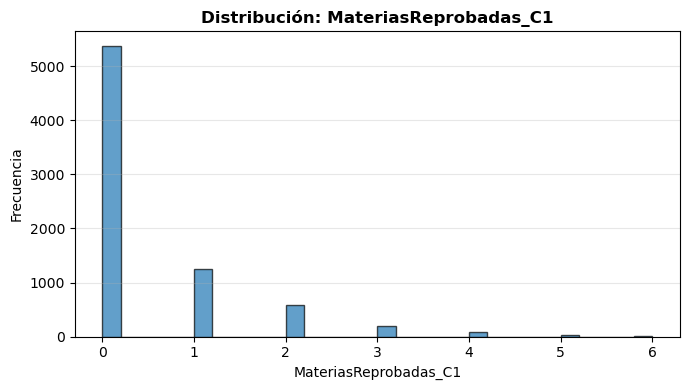

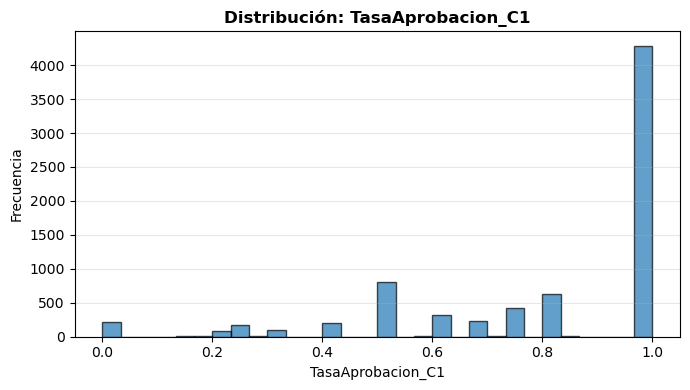

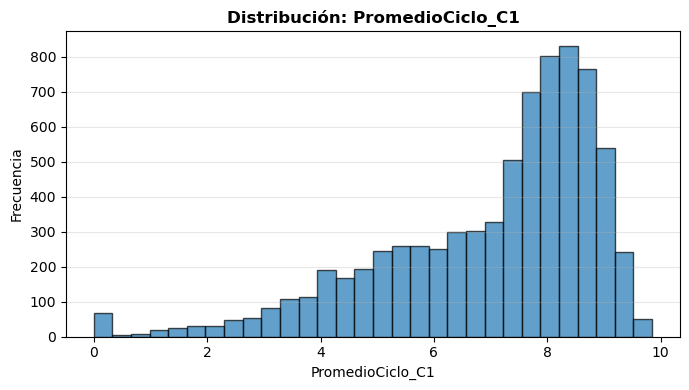

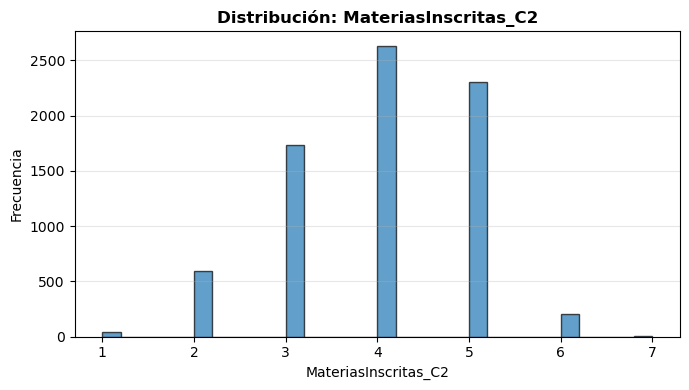

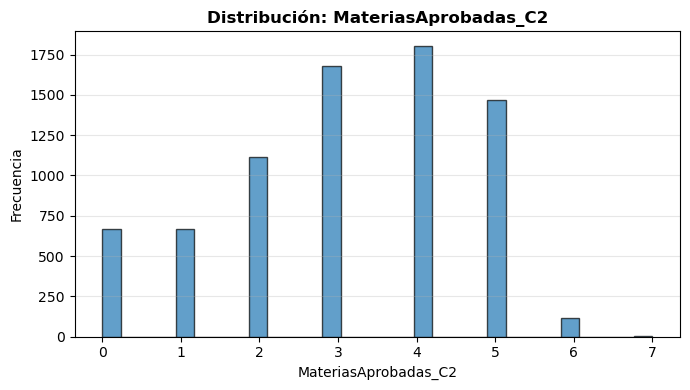

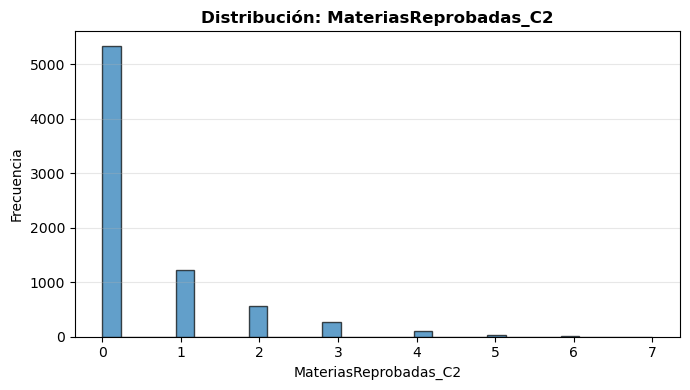

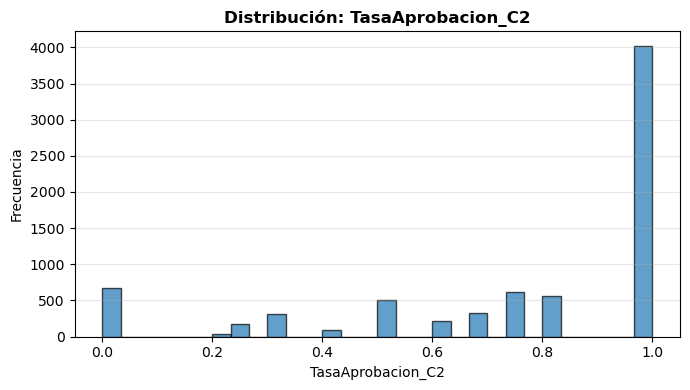

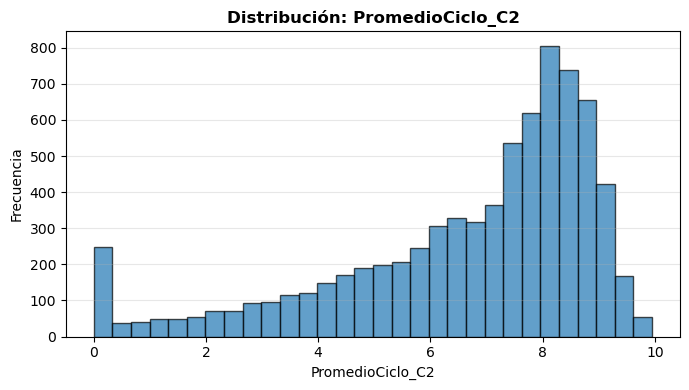

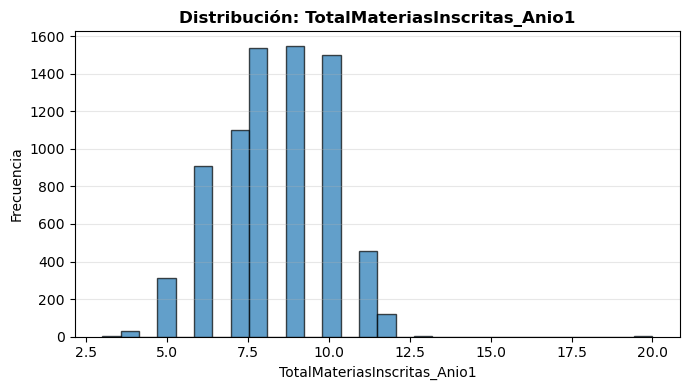

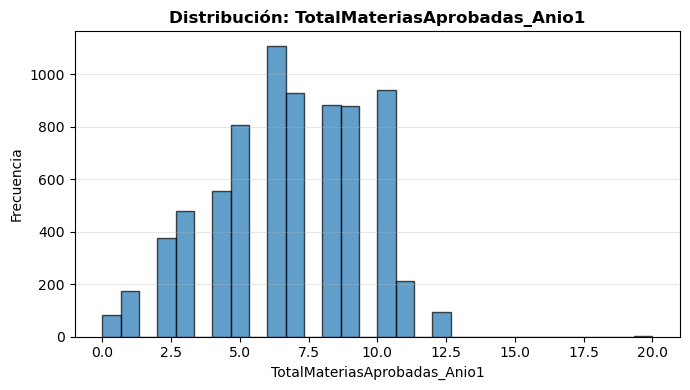

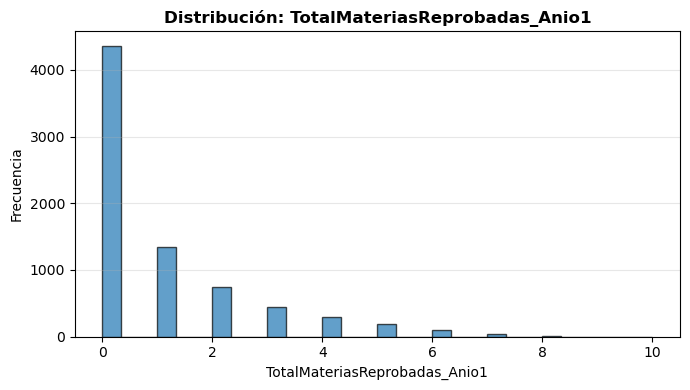

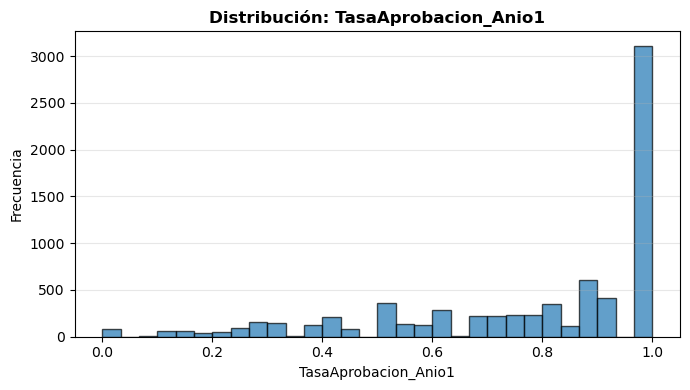

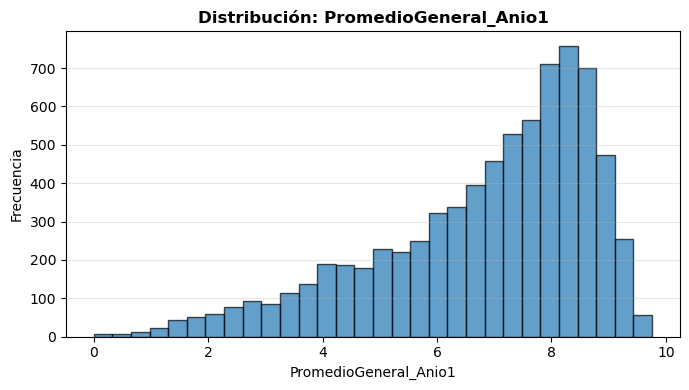

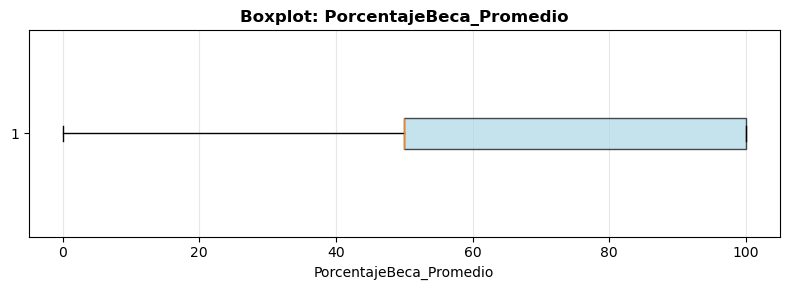

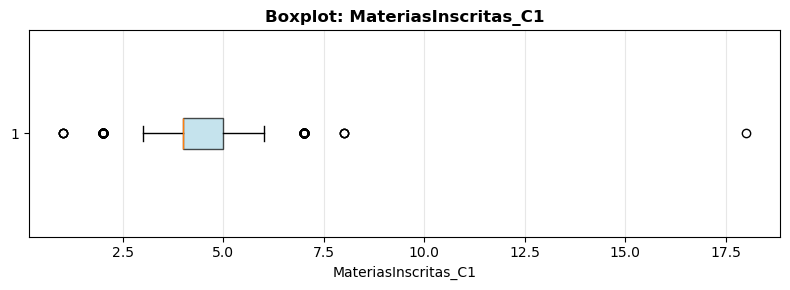

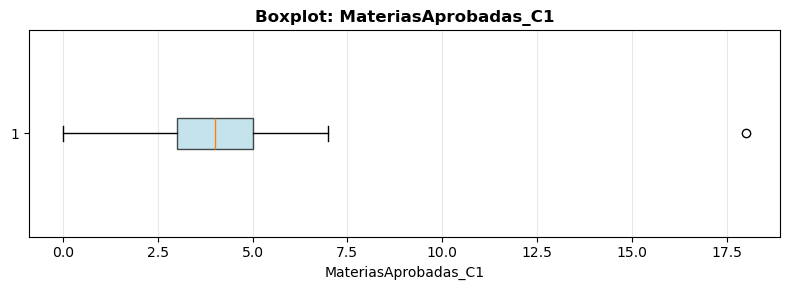

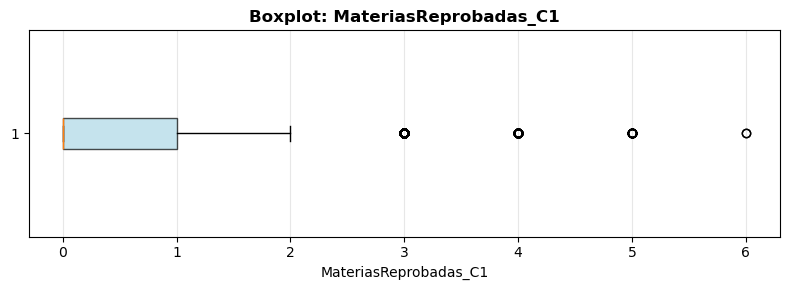

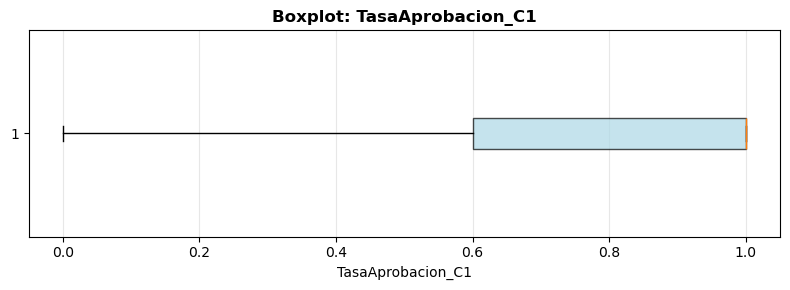

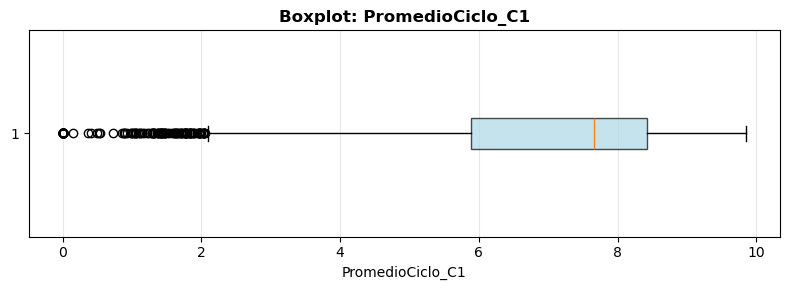

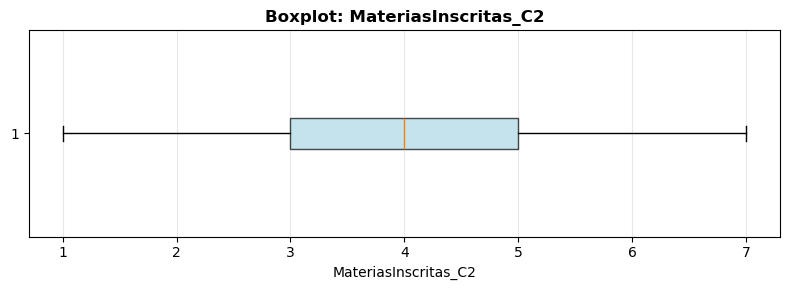

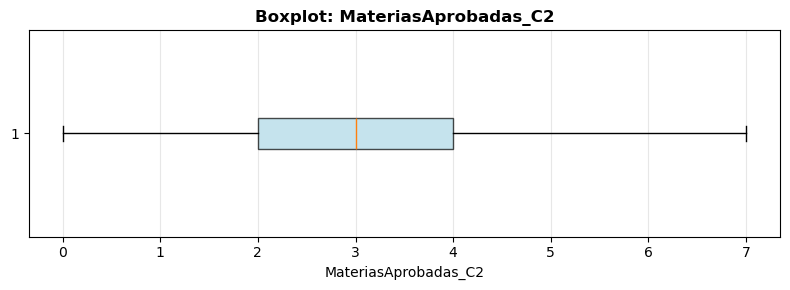

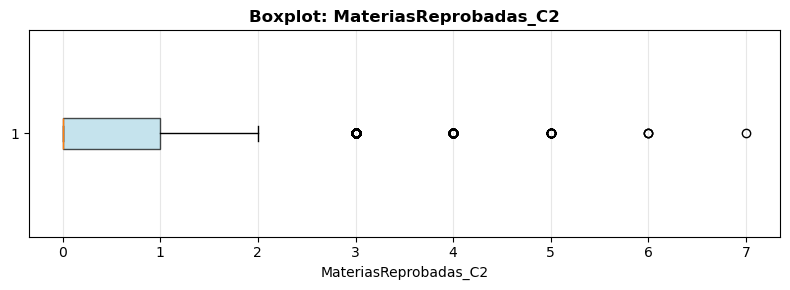

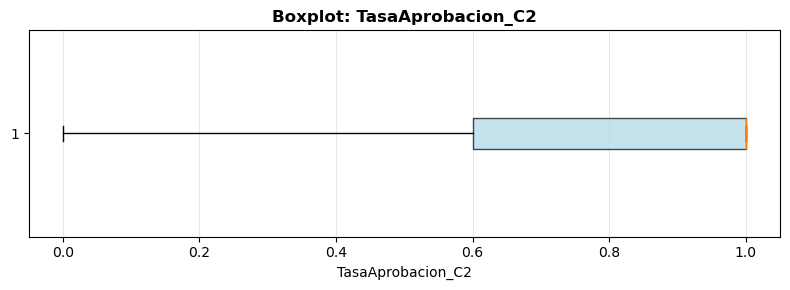

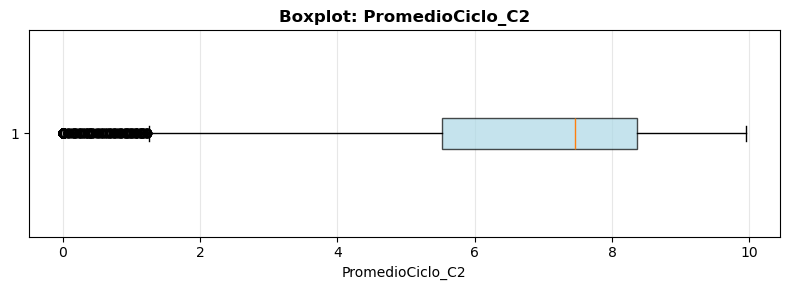

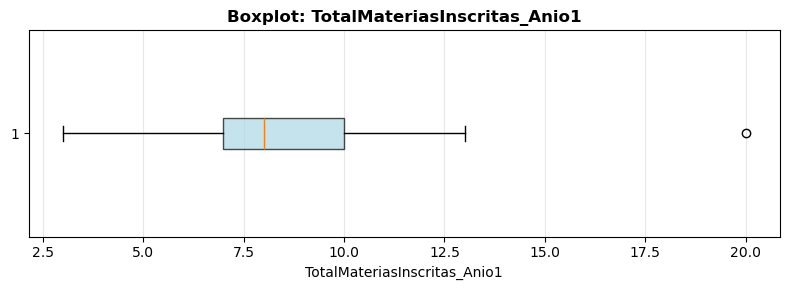

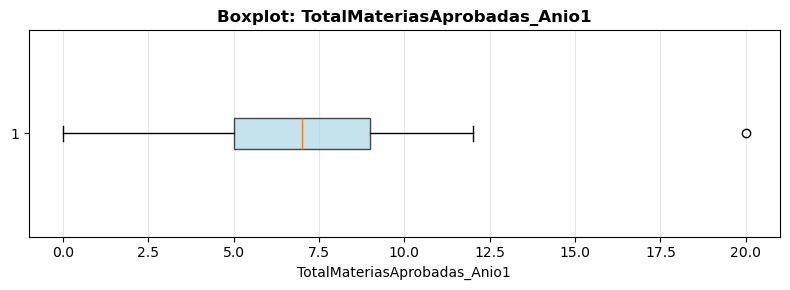

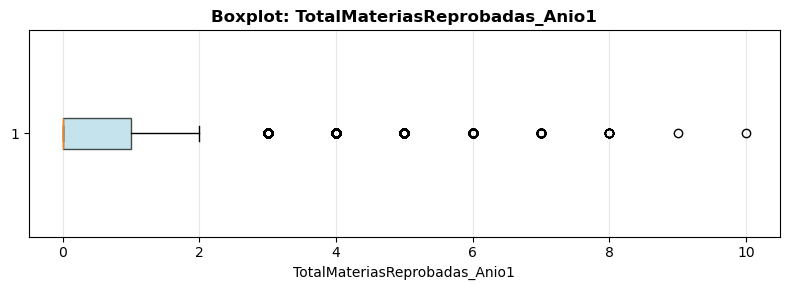

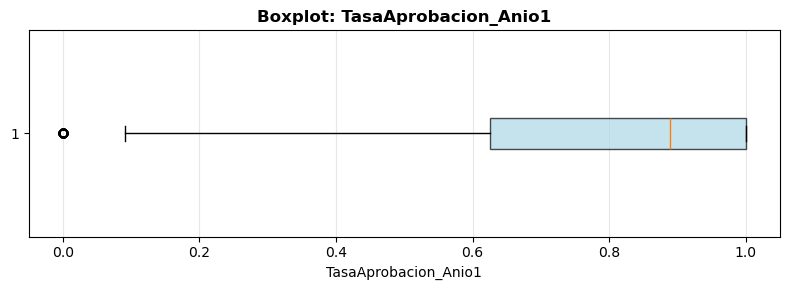

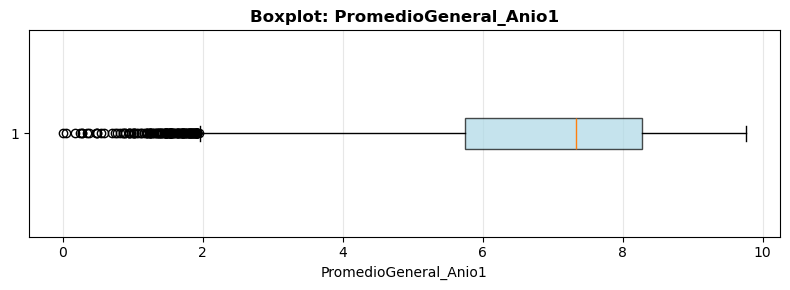

In [9]:

print("ANÁLISIS DE VARIABLES NUMÉRICAS")

# Histogramas de variables numéricas
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    plt.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.title(f"Distribución: {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Frecuencia", fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Boxplots para detectar outliers
for col in numeric_cols:
    plt.figure(figsize=(8, 3))
    plt.boxplot(df[col].dropna(), vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
    plt.title(f"Boxplot: {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

ANÁLISIS DE VARIABLES CATEGÓRICAS


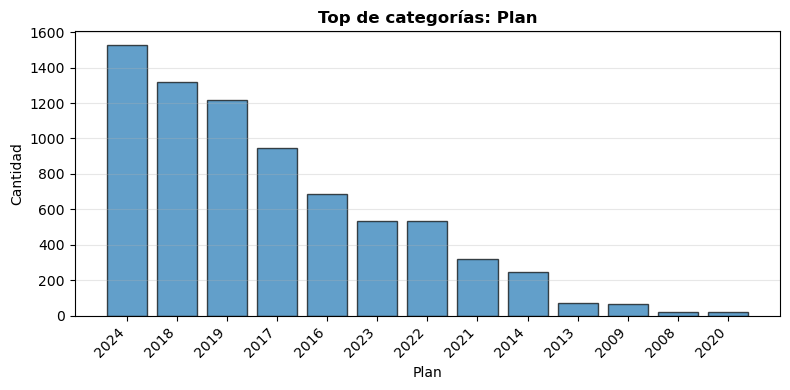

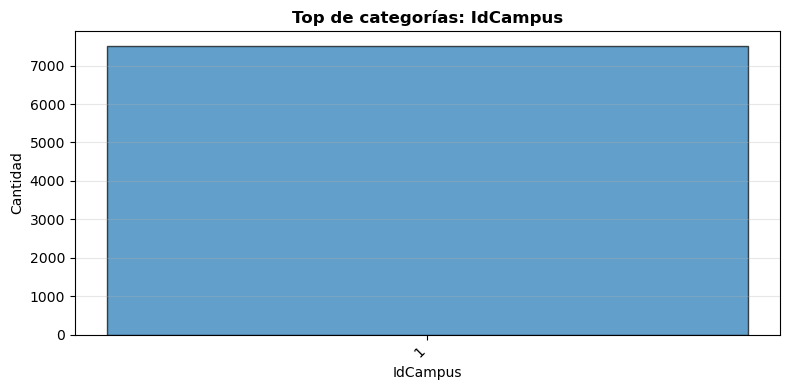

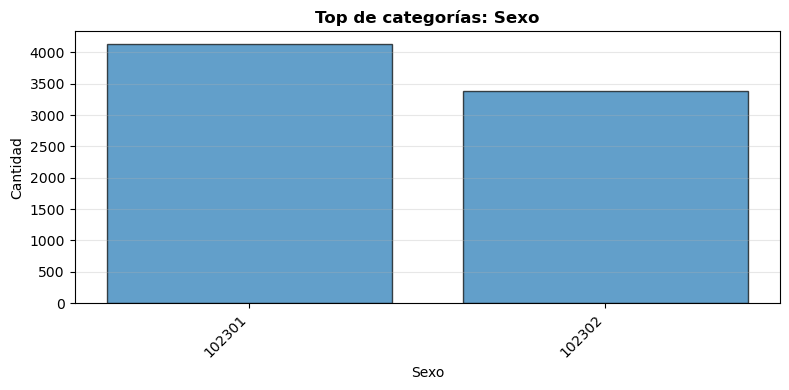

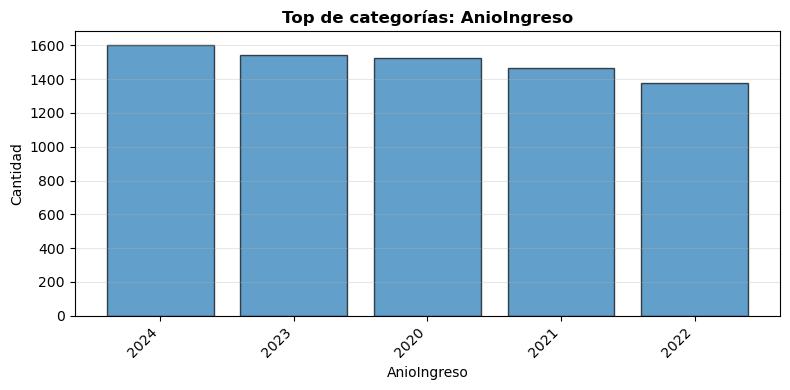

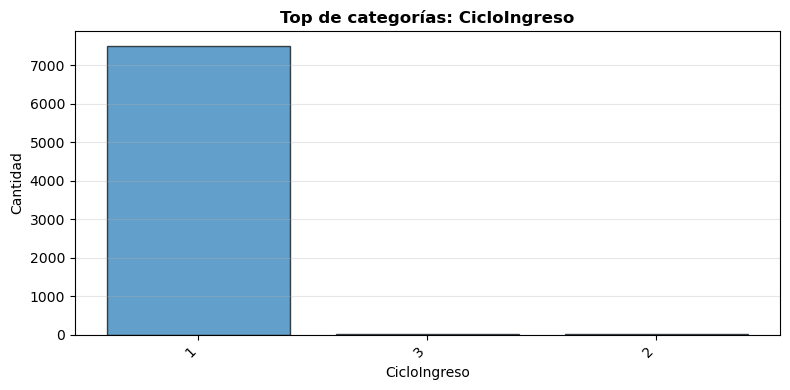

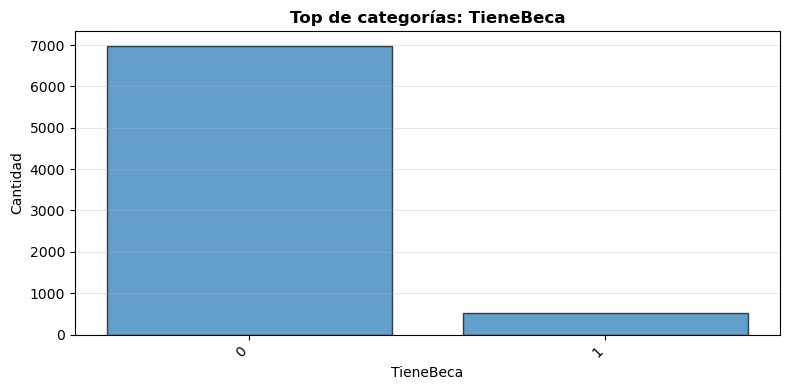

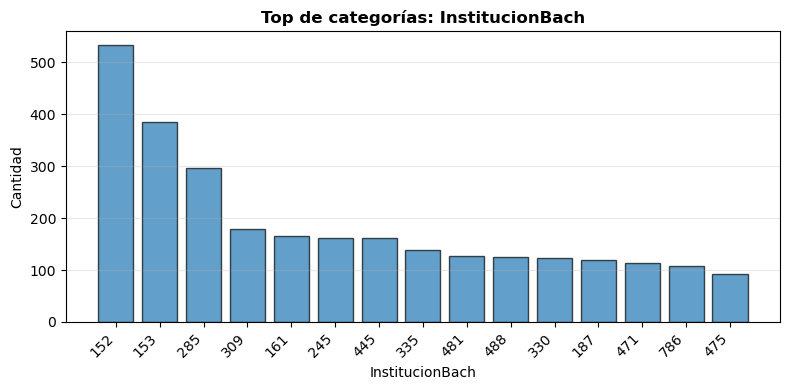

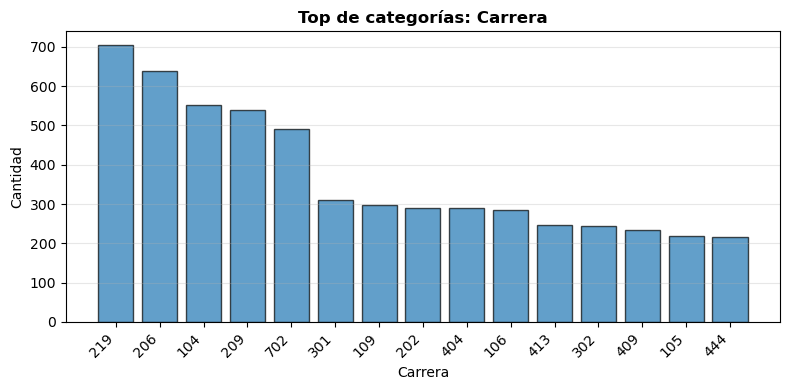

In [10]:

# Análisis de variables categóricas
print("ANÁLISIS DE VARIABLES CATEGÓRICAS")

# Conteos de variables categóricas
for col in categorical_cols:
    vc = df[col].value_counts().head(15)  # top 15 categorías
    
    plt.figure(figsize=(8, 4))
    plt.bar(vc.index.astype(str), vc.values, edgecolor='black', alpha=0.7)
    plt.title(f"Top de categorías: {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Cantidad", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### 3.3 Valores faltantes (missing values)

- Se calcula el porcentaje de nulos por columna.
- Se visualiza un resumen.


ANÁLISIS DE VALORES NULOS

 Columnas con valores nulos: 1

Top de columnas con mayor porcentaje de nulos:
PorcentajeBeca_Promedio    0.929085
dtype: float64


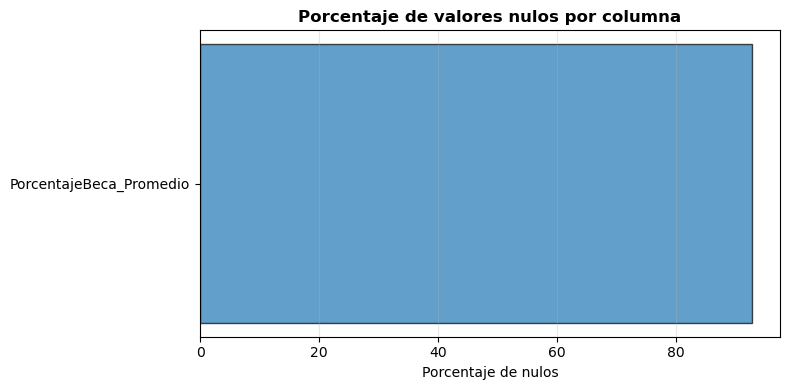

In [11]:

# 3.5. Análisis de valores nulos

print("ANÁLISIS DE VALORES NULOS")

missing = df.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]

print(f"\n Columnas con valores nulos: {len(missing)}")
if len(missing) > 0:
    print("\nTop de columnas con mayor porcentaje de nulos:")
    print(missing.head(20))
    
    # Gráfico de porcentaje de nulos por columna
    plt.figure(figsize=(8, max(4, 0.3*len(missing))))
    plt.barh(missing.index[::-1], (missing.values[::-1]*100), edgecolor='black', alpha=0.7)
    plt.title("Porcentaje de valores nulos por columna", fontsize=12, fontweight='bold')
    plt.xlabel("Porcentaje de nulos", fontsize=10)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n No hay valores nulos en el dataset.")

### 3.4 Análisis bivariado/multivariado

- Relación de cada feature con `Deserto`.
- Correlación entre variables numéricas.


CORRELACIÓN CON LA VARIABLE OBJETIVO

Top correlaciones con 'Deserto':
TasaAprobacion_C2               -0.367550
PromedioCiclo_C2                -0.346837
MateriasReprobadas_C2            0.317029
MateriasAprobadas_C2            -0.315248
TasaAprobacion_Anio1            -0.305645
PromedioGeneral_Anio1           -0.296979
TotalMateriasReprobadas_Anio1    0.293801
TotalMateriasAprobadas_Anio1    -0.248485
MateriasReprobadas_C1            0.164547
TasaAprobacion_C1               -0.163663
PromedioCiclo_C1                -0.162042
MateriasAprobadas_C1            -0.120798
MateriasInscritas_C2            -0.090356
TotalMateriasInscritas_Anio1    -0.041711
MateriasInscritas_C1             0.022222
Name: Deserto, dtype: float64


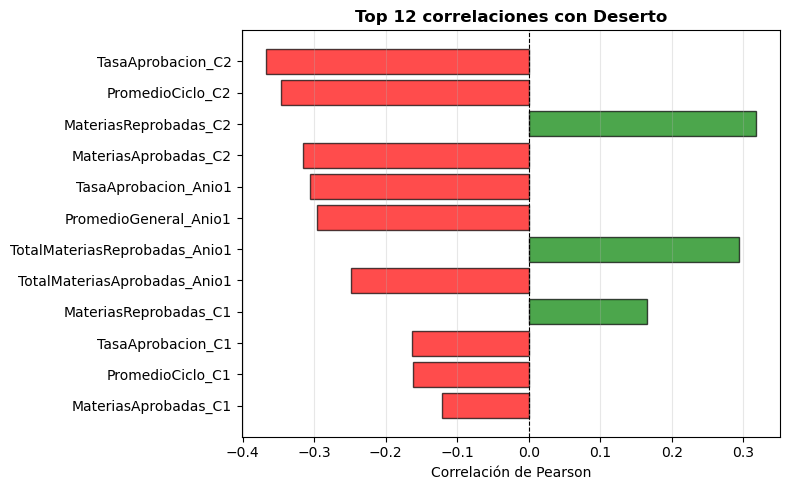

In [12]:

print("CORRELACIÓN CON LA VARIABLE OBJETIVO")

# Correlación con la variable objetivo (solo numéricas)
corr = df[numeric_cols + [target_col]].corr(numeric_only=True)[target_col].drop(target_col).sort_values(key=lambda s: s.abs(), ascending=False)

print("\nTop correlaciones con 'Deserto':")
print(corr.head(15))

# Gráfico: Top correlaciones absolutas con Deserto
topk = min(12, len(corr))
top_corr = corr.iloc[:topk][::-1]

plt.figure(figsize=(8, 5))
colors = ['red' if x < 0 else 'green' for x in top_corr.values]
plt.barh(top_corr.index, top_corr.values, color=colors, edgecolor='black', alpha=0.7)
plt.title(f"Top {topk} correlaciones con Deserto", fontsize=12, fontweight='bold')
plt.xlabel("Correlación de Pearson", fontsize=10)
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


TASA DE DESERCIÓN POR CATEGORÍA

--- Tasa de deserción por Plan ---
      count  tasa_desercion
Plan                       
2024   1528        0.112565
2018   1316        0.116261
2019   1219        0.111567
2017    944        0.121822
2016    689        0.084180
2023    537        0.094972
2022    533        0.140713
2021    319        0.056426
2014    249        0.120482
2013     74        0.310811


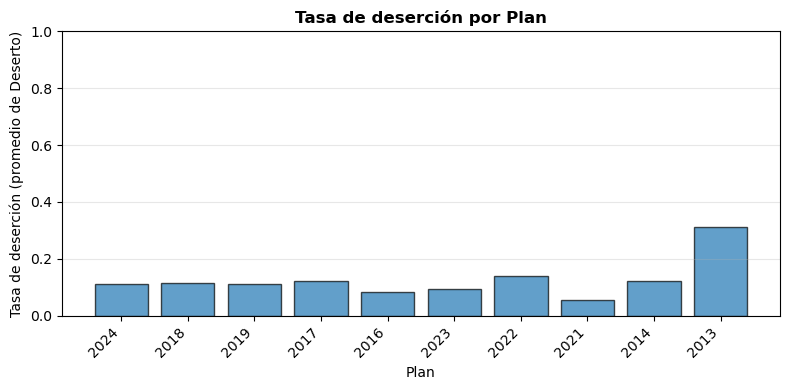


--- Tasa de deserción por IdCampus ---
          count  tasa_desercion
IdCampus                       
1          7516        0.113491


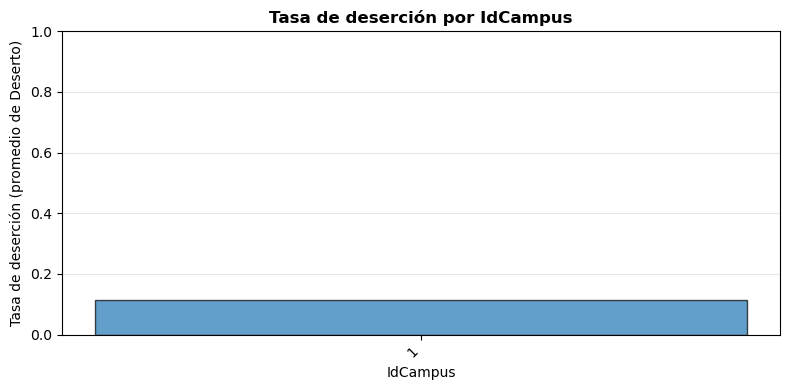


--- Tasa de deserción por Sexo ---
        count  tasa_desercion
Sexo                         
102301   4128        0.143169
102302   3388        0.077332


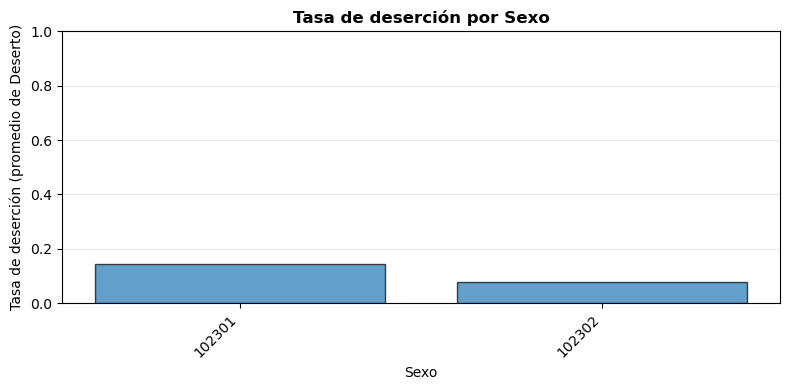


--- Tasa de deserción por AnioIngreso ---
             count  tasa_desercion
AnioIngreso                       
2024          1603        0.120399
2023          1541        0.091499
2020          1524        0.108268
2021          1468        0.115123
2022          1380        0.134058


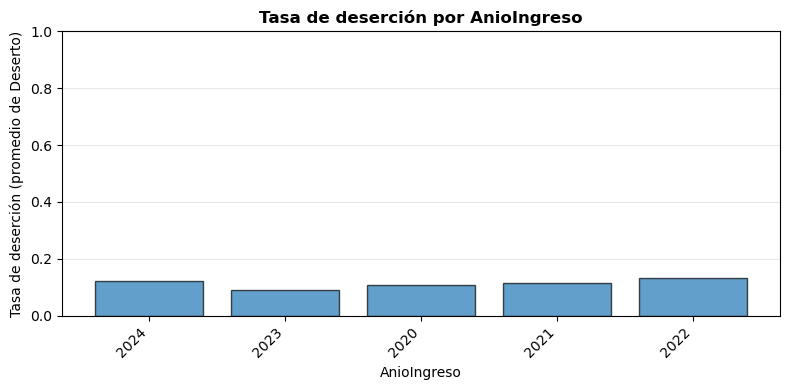


--- Tasa de deserción por CicloIngreso ---
              count  tasa_desercion
CicloIngreso                       
1              7504        0.113539
3                10        0.100000
2                 2        0.000000


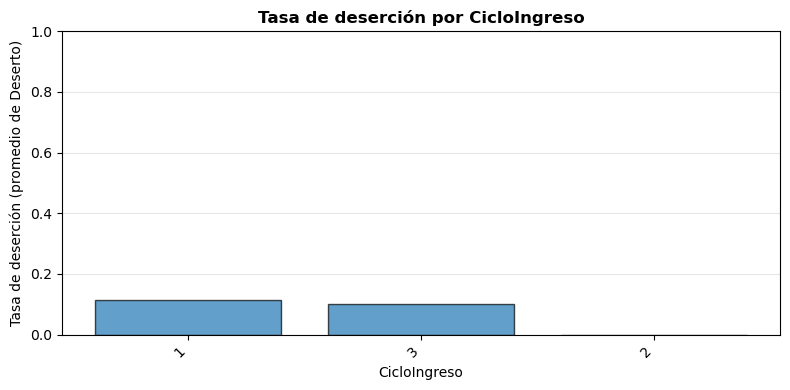


--- Tasa de deserción por TieneBeca ---
           count  tasa_desercion
TieneBeca                       
0           6983        0.118144
1            533        0.052533


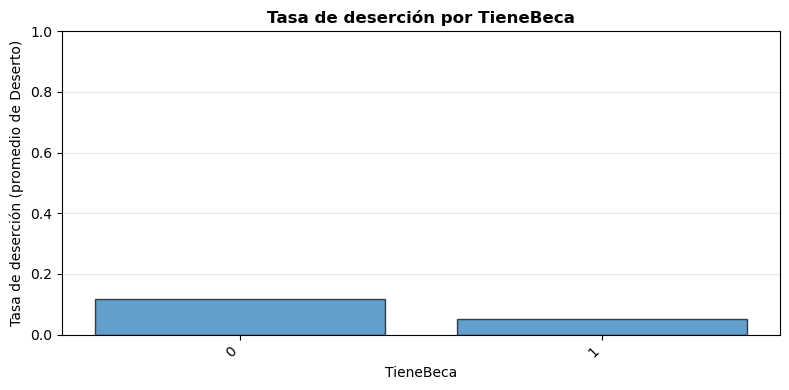


--- Tasa de deserción por InstitucionBach ---
                 count  tasa_desercion
InstitucionBach                       
152                533        0.174484
153                385        0.093506
285                297        0.101010
309                180        0.077778
161                165        0.115152
245                162        0.074074
445                161        0.118012
335                139        0.021583
481                127        0.141732
488                126        0.047619


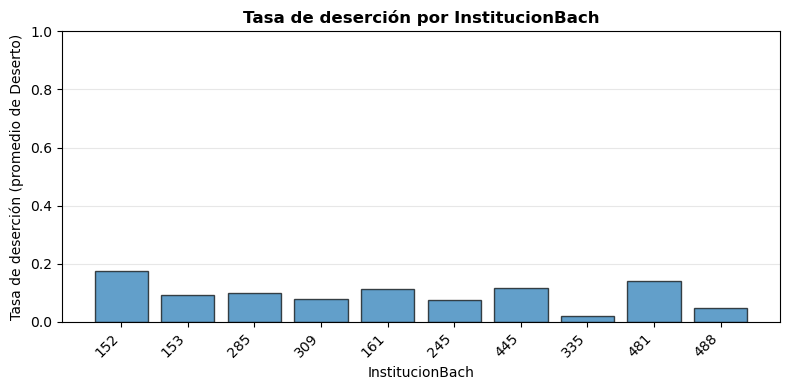


--- Tasa de deserción por Carrera ---
         count  tasa_desercion
Carrera                       
219        704        0.102273
206        639        0.092332
104        553        0.106691
209        538        0.059480
702        492        0.144309
301        309        0.074434
109        298        0.137584
202        290        0.065517
404        289        0.134948
106        286        0.122378


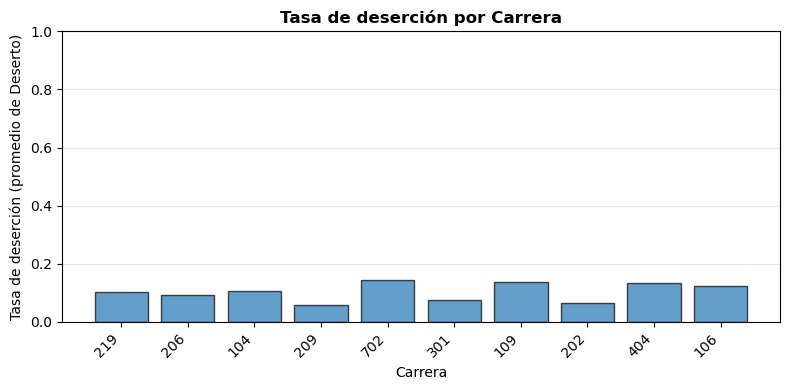

In [13]:

print("TASA DE DESERCIÓN POR CATEGORÍA")

# Tasa de deserción por categoría para columnas categóricas
for col in categorical_cols:
    tmp = (
        df.groupby(col)[target_col]
          .agg(['count', 'mean'])
          .rename(columns={'mean': 'tasa_desercion'})
          .sort_values('count', ascending=False)
          .head(10)
    )
    
    print(f"\n--- Tasa de deserción por {col} ---")
    print(tmp)
    
    plt.figure(figsize=(8, 4))
    plt.bar(tmp.index.astype(str), tmp['tasa_desercion'].values, edgecolor='black', alpha=0.7)
    plt.title(f"Tasa de deserción por {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Tasa de deserción (promedio de Deserto)", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

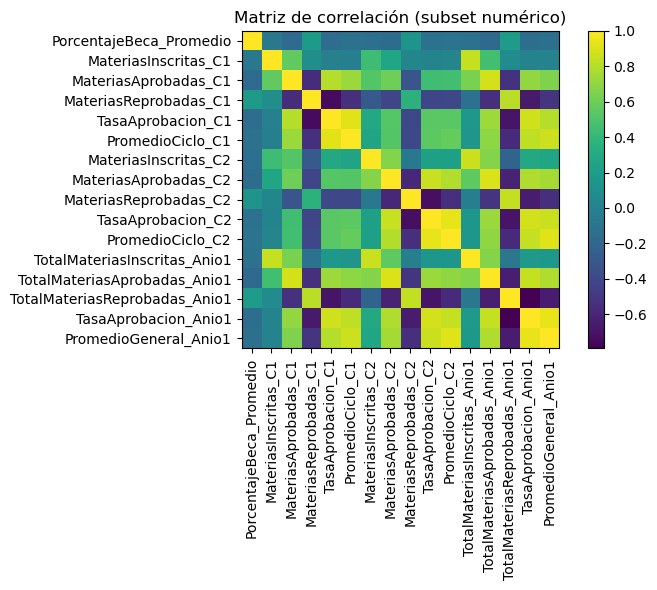

In [14]:
# Matriz de correlación entre numéricas (muestra: primeras 12 para legibilidad)
num_subset = numeric_cols
corr_mat = df[num_subset].corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr_mat.values)
plt.title("Matriz de correlación (subset numérico)")
plt.xticks(range(len(num_subset)), num_subset, rotation=90)
plt.yticks(range(len(num_subset)), num_subset)
plt.colorbar()
plt.tight_layout()
plt.show()


## 4. División de datos y estrategia de validación

### Objetivo
Separar los datos en conjuntos de **entrenamiento (train)** y **prueba (test)**. Este paso es crucial y debe realizarse antes del preprocesamiento para evitar la "fuga de datos" (data leakage), donde la información del conjunto de prueba influye indirectamente en el entrenamiento del modelo.

### Estrategia de División y Validación
- **División Train/Test:** Se utiliza una proporción de 80% para entrenamiento y 20% para prueba.
- **Estratificación:** Se aplica estratificación por la variable `Deserto` para asegurar que ambos conjuntos (train y test) mantengan la misma proporción de clases que el dataset original. Esto es vital en problemas con clases desbalanceadas.
- **Semilla Aleatoria:** Se fija una semilla (`random_state = 42`) para garantizar que la división sea reproducible.
- **Validación Cruzada (Cross-Validation):** Durante el entrenamiento, se usará `StratifiedKFold` con 5 divisiones (folds) sobre el conjunto de entrenamiento. Esto permite una evaluación robusta del modelo y ayuda a optimizar los hiperparámetros sin tocar el conjunto de prueba.

> El conjunto de prueba (`test`) se reserva y se utiliza **una única vez** al final del proceso para evaluar el rendimiento del modelo final seleccionado.

In [15]:
# División del dataset (Train/Test)

print("DIVISIÓN DEL DATASET")

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"\n Train: {X_train.shape}, Test: {X_test.shape}")

print("\nProporción de clases en y (total):")
print(y.value_counts(normalize=True).round(4))

print("\nProporción de clases en y_train:")
print(y_train.value_counts(normalize=True).round(4))

print("\nProporción de clases en y_test:")
print(y_test.value_counts(normalize=True).round(4))

DIVISIÓN DEL DATASET

 Train: (6012, 24), Test: (1504, 24)

Proporción de clases en y (total):
Deserto
0    0.8865
1    0.1135
Name: proportion, dtype: float64

Proporción de clases en y_train:
Deserto
0    0.8866
1    0.1134
Name: proportion, dtype: float64

Proporción de clases en y_test:
Deserto
0    0.8863
1    0.1137
Name: proportion, dtype: float64


In [16]:

# Configuración de validación cruzada estratificada

print("CONFIGURACIÓN DE VALIDACIÓN CRUZADA")

# Configuración de Cross-Validation Estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tamaños por fold
fold_sizes = []
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    fold_sizes.append((fold, len(tr_idx), len(val_idx)))

fold_df = pd.DataFrame(fold_sizes, columns=["fold", "train_size", "val_size"])
print("\n Tamaños de cada fold:")
print(fold_df)


CONFIGURACIÓN DE VALIDACIÓN CRUZADA

 Tamaños de cada fold:
   fold  train_size  val_size
0     1        4809      1203
1     2        4809      1203
2     3        4810      1202
3     4        4810      1202
4     5        4810      1202


## 5. Preprocesamiento y Feature Engineering

In [17]:

#  Definición de transformadores (Preprocesamiento)
print("CONFIGURACIÓN DEL PREPROCESAMIENTO")


# Pipeline para variables numéricas: Imputación por mediana + Escalado estándar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas: Imputación por valor más frecuente + One-Hot Encoding
# Cambiamos la estrategia a 'most_frequent' para evitar problemas con int64
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print(f" Preprocesador configurado para {len(numeric_cols)} numéricas y {len(categorical_cols)} categóricas.")


# Definición de Modelos y Grillas de Hiperparámetros


# 1. Regresión Logística (Baseline)
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2']
}

# 2. K-Nearest Neighbors (Basado en Distancia)
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 11],
    'classifier__weights': ['uniform', 'distance']
}

# 3. XGBoost (Ensamble de Gradient Boosting)
# Calculamos el factor de desbalance para scale_pos_weight
ratio_desbalance = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss',
        scale_pos_weight=ratio_desbalance # Manejo de desbalance
    ))
])

xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

# Lista de modelos para iterar
models_to_train = [
    ("Regresión Logística", lr_model, lr_param_grid),
    ("K-Nearest Neighbors", knn_model, knn_param_grid),
    ("XGBoost", xgb_model, xgb_param_grid)
]

print("\n Modelos configurados:")
for name, _, params in models_to_train:
    print(f"  - {name}: {len(list(params.values())[0]) if params else 0} combinaciones de hiperparámetros")

CONFIGURACIÓN DEL PREPROCESAMIENTO
 Preprocesador configurado para 16 numéricas y 8 categóricas.

 Modelos configurados:
  - Regresión Logística: 4 combinaciones de hiperparámetros
  - K-Nearest Neighbors: 4 combinaciones de hiperparámetros
  - XGBoost: 2 combinaciones de hiperparámetros


## 6, 7 y 8. Entrenamiento, optimización de hiperparámetros y comparación de modelos

ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS

ENTRENANDO Regresión Logística...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Regresión Logística finalizado en 11.69s
Mejores parámetros: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}

ENTRENANDO K-Nearest Neighbors...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 K-Nearest Neighbors finalizado en 3.97s
Mejores parámetros: {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}

ENTRENANDO XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\arani\anaconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:19:08] WARNING: D:\bld\xgboost-split_1770963345048\work\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost finalizado en 58.05s
Mejores parámetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

RESUMEN DE RENDIMIENTO EN TEST
             Modelo  Mejor F1 (CV)  F1-Score (Test)  Recall (Test)  Precision (Test)  Accuracy (Test)  Tiempo (s)
            XGBoost         0.4520           0.4730         0.6140            0.3846           0.8444       58.05
Regresión Logística         0.4213           0.4507         0.7485            0.3224           0.7926       11.69
K-Nearest Neighbors         0.3820           0.3830         0.3158            0.4865           0.8843        3.97


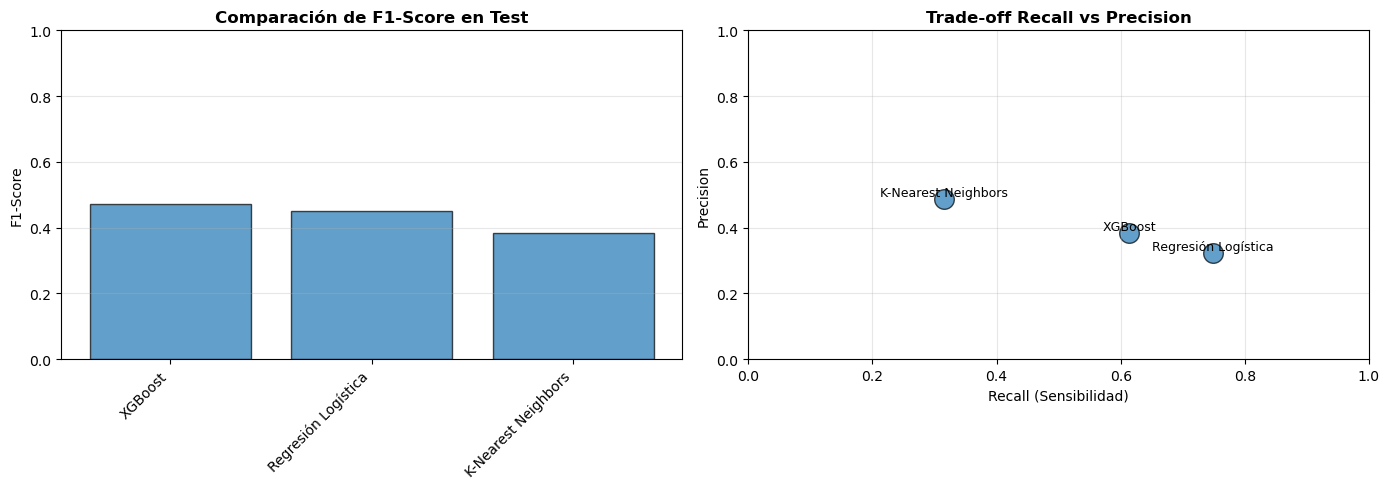

In [18]:
print("ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS")

best_models = {}
results_summary = []

for name, pipeline, params in models_to_train:
    print(f"\nENTRENANDO {name}...")
    start_time = time.time()
    
    # Usamos F1-Score como métrica de optimización debido al contexto de deserción
    grid_search = GridSearchCV(
        pipeline, 
        params, 
        cv=skf, 
        scoring='f1', # Optimizamos para balancear precisión y recall
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    
    # Guardar el mejor modelo
    best_models[name] = grid_search.best_estimator_
    
    # Evaluación en Test
    y_pred = grid_search.predict(X_test)
    
    metrics = {
        "Modelo": name,
        "Mejor F1 (CV)": round(grid_search.best_score_, 4),
        "F1-Score (Test)": round(f1_score(y_test, y_pred), 4),
        "Recall (Test)": round(recall_score(y_test, y_pred), 4),
        "Precision (Test)": round(precision_score(y_test, y_pred), 4),
        "Accuracy (Test)": round(accuracy_score(y_test, y_pred), 4),
        "Tiempo (s)": round(end_time - start_time, 2)
    }
    
    results_summary.append(metrics)
    print(f" {name} finalizado en {metrics['Tiempo (s)']}s")
    print(f"Mejores parámetros: {grid_search.best_params_}")


#  Resumen de Resultados

df_results = pd.DataFrame(results_summary).sort_values(by="F1-Score (Test)", ascending=False)
print("\n" + "="*60)
print("RESUMEN DE RENDIMIENTO EN TEST")
print("="*60)
print(df_results.to_string(index=False))

# Visualización comparativa de métricas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: F1-Score comparativo
ax1 = axes[0]
x_pos = range(len(df_results))
ax1.bar(x_pos, df_results["F1-Score (Test)"], alpha=0.7, edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_results["Modelo"], rotation=45, ha='right')
ax1.set_ylabel("F1-Score", fontsize=10)
ax1.set_title("Comparación de F1-Score en Test", fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Recall vs Precision
ax2 = axes[1]
ax2.scatter(df_results["Recall (Test)"], df_results["Precision (Test)"], 
            s=200, alpha=0.7, edgecolor='black')
for i, model in enumerate(df_results["Modelo"]):
    ax2.annotate(model, 
                 (df_results["Recall (Test)"].iloc[i], df_results["Precision (Test)"].iloc[i]),
                 fontsize=9, ha='center', va='bottom')
ax2.set_xlabel("Recall (Sensibilidad)", fontsize=10)
ax2.set_ylabel("Precision", fontsize=10)
ax2.set_title("Trade-off Recall vs Precision", fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Selección y evaluación del modelo final

In [19]:
# Selección e Interpretación del Modelo Final (XGBoost)
# Selección del modelo final (Desempeño + negocio + tiempo)


# F1-Score en TEST
final_model_name = df_results.sort_values("F1-Score (Test)", ascending=False).iloc[0]["Modelo"]
final_model = best_models[final_model_name]

print("\n" + "="*70)
print("MODELO FINAL SELECCIONADO")
print("="*70)
print(f"Modelo final: {final_model_name}")

# Métricas
row = df_results[df_results["Modelo"] == final_model_name].iloc[0]
print("\nJustificación basada en métricas relevantes (TEST):")
print(f"- F1-Score (Test): {row['F1-Score (Test)']:.4f}  (criterio principal por desbalance)")
print(f"- Recall (Test)  : {row['Recall (Test)']:.4f}")
print(f"- Precision (Test): {row['Precision (Test)']:.4f}")
print(f"- Accuracy (Test): {row['Accuracy (Test)']:.4f}")
print(f"- Tiempo entrenamiento (s): {row['Tiempo (s)']:.2f}")



MODELO FINAL SELECCIONADO
Modelo final: XGBoost

Justificación basada en métricas relevantes (TEST):
- F1-Score (Test): 0.4730  (criterio principal por desbalance)
- Recall (Test)  : 0.6140
- Precision (Test): 0.3846
- Accuracy (Test): 0.8444
- Tiempo entrenamiento (s): 58.05



ROBUSTEZ / GENERALIZACIÓN (CV en Train)
F1       : 0.4520 ± 0.0179
RECALL   : 0.5557 ± 0.0193
PRECISION: 0.3814 ± 0.0214
ACCURACY : 0.8470 ± 0.0082

TIEMPO DE INFERENCIA (aprox.)
Inferencia sobre 1504 registros: 0.0155s  |  0.010304 ms/registro

EVALUACIÓN DETALLADA DEL MODELO FINAL (TEST)
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1333
           1       0.38      0.61      0.47       171

    accuracy                           0.84      1504
   macro avg       0.67      0.74      0.69      1504
weighted avg       0.88      0.84      0.86      1504



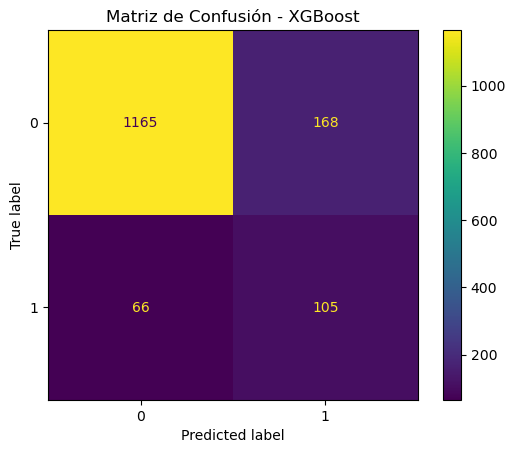

ROC-AUC (Test): 0.8303
PR-AUC / Average Precision (Test): 0.5051


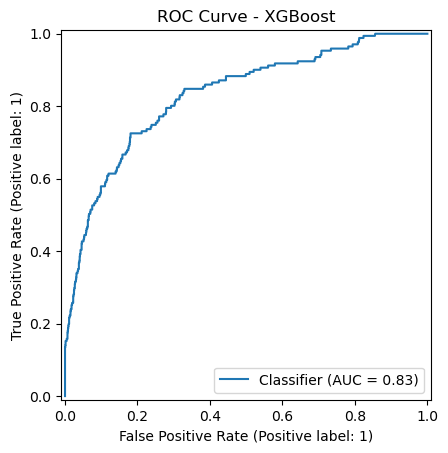

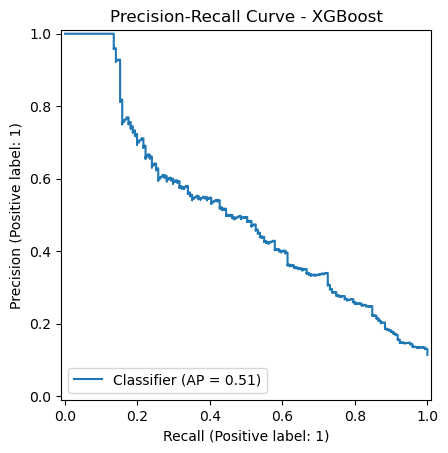

In [20]:
# Robustez y generalización (CV)

skf_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"f1": "f1", "recall": "recall", "precision": "precision", "accuracy": "accuracy"}

cv_out = cross_validate(final_model, X_train, y_train, cv=skf_final, scoring=scoring, n_jobs=-1)

print("\n" + "="*70)
print("ROBUSTEZ / GENERALIZACIÓN (CV en Train)")
print("="*70)
for k in ["test_f1", "test_recall", "test_precision", "test_accuracy"]:
    print(f"{k.replace('test_', '').upper():9s}: {cv_out[k].mean():.4f} ± {cv_out[k].std():.4f}")

# Tiempo de inferencia

N_INFER = min(5000, len(X_test))
X_infer = X_test.iloc[:N_INFER].copy() if hasattr(X_test, "iloc") else X_test[:N_INFER]

t0 = time.time()
_ = final_model.predict(X_infer)
t1 = time.time()

print("\n" + "="*70)
print("TIEMPO DE INFERENCIA (aprox.)")
print("="*70)
print(f"Inferencia sobre {N_INFER} registros: {(t1 - t0):.4f}s  |  {(t1 - t0)/N_INFER*1000:.6f} ms/registro")

# Interpretación del modelo (XGBoost)

# Evaluación detallada en TEST (reporte, matriz, ROC/PR)


y_pred_final = final_model.predict(X_test)

print("\n" + "="*70)
print("EVALUACIÓN DETALLADA DEL MODELO FINAL (TEST)")
print("="*70)
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='d')
plt.title(f"Matriz de Confusión - {final_model_name}")
plt.show()

# Curvas ROC y PR
if hasattr(final_model, "predict_proba"):
    y_proba_final = final_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba_final)
    ap = average_precision_score(y_test, y_proba_final)

    print(f"ROC-AUC (Test): {roc_auc:.4f}")
    print(f"PR-AUC / Average Precision (Test): {ap:.4f}")

    RocCurveDisplay.from_predictions(y_test, y_proba_final)
    plt.title(f"ROC Curve - {final_model_name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba_final)
    plt.title(f"Precision-Recall Curve - {final_model_name}")
    plt.show()
else:
    print("[INFO] El modelo no soporta predict_proba")



FEATURE IMPORTANCE (XGBoost)
Top 20 variables más influyentes:
num__TasaAprobacion_C2               0.061068
cat__Carrera_703                     0.029233
num__MateriasAprobadas_C2            0.020208
cat__Carrera_208                     0.019513
cat__InstitucionBach_152             0.012723
cat__InstitucionBach_121             0.011457
cat__InstitucionBach_580             0.011366
cat__InstitucionBach_621             0.009533
num__TotalMateriasInscritas_Anio1    0.008898
cat__Carrera_405                     0.008636
cat__CicloIngreso_3                  0.008634
cat__InstitucionBach_451             0.008328
cat__InstitucionBach_330             0.008226
cat__InstitucionBach_1370            0.008146
cat__Carrera_203                     0.007838
cat__InstitucionBach_576             0.007693
cat__Carrera_402                     0.007363
cat__Carrera_211                     0.007223
cat__InstitucionBach_253             0.007109
cat__InstitucionBach_18              0.007095


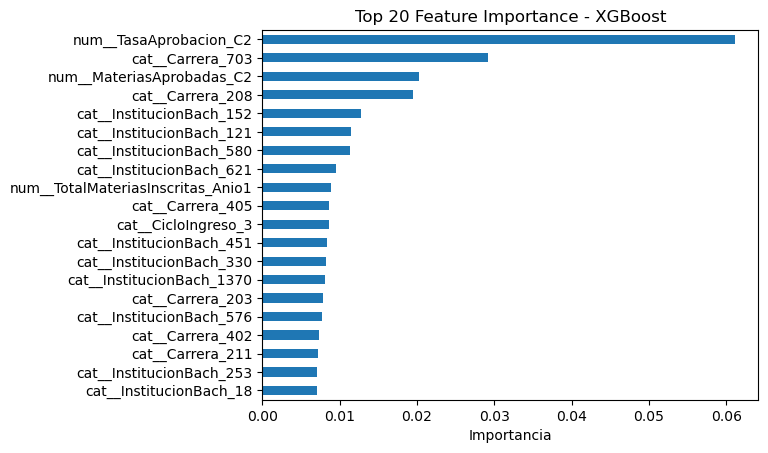


Interpretación:
- La importancia es una medida global de contribución del feature al modelo.
- No implica causalidad; indica qué variables ayudan más a separar clases.

ANÁLISIS DE ERRORES (FN/FP)
Falsos Negativos (FN): 66  -> (casos positivos no detectados)
Falsos Positivos (FP): 168  -> (alertas incorrectas)

Ejemplos FN (top):


,Carrera,Plan,IdCampus,Sexo,AnioIngreso,CicloIngreso,InstitucionBach,TieneBeca,PorcentajeBeca_Promedio,MateriasInscritas_C1,MateriasAprobadas_C1,MateriasReprobadas_C1,TasaAprobacion_C1,PromedioCiclo_C1,MateriasInscritas_C2,MateriasAprobadas_C2,MateriasReprobadas_C2,TasaAprobacion_C2,PromedioCiclo_C2,TotalMateriasInscritas_Anio1,TotalMateriasAprobadas_Anio1,TotalMateriasReprobadas_Anio1,TasaAprobacion_Anio1,PromedioGeneral_Anio1,y_real,y_pred
19,106,2017,1,102302,2020,1,279,0,NaN,4,2,2,0.5000,6.52,3,1,1,0.3333,4.17,7,3,3,0.4286,5.35,1,0
22,104,2024,1,102301,2024,1,153,0,NaN,4,2,2,0.5000,6.69,4,2,0,0.5000,4.49,8,4,2,0.5000,5.59,1,0
27,109,2022,1,102301,2023,1,153,0,NaN,4,1,1,0.2500,3.06,3,1,2,0.3333,5.25,7,2,3,0.2857,4.15,1,0
40,104,2024,1,102301,2024,1,176,0,NaN,4,2,1,0.5000,5.59,3,1,1,0.3333,4.89,7,3,2,0.4286,5.24,1,0
54,104,2017,1,102302,2021,1,481,0,NaN,4,1,3,0.2500,3.69,2,1,1,0.5000,5.01,6,2,4,0.3333,4.35,1,0
60,206,2021,1,102302,2022,1,187,0,NaN,3,3,0,1.0000,7.88,5,5,0,1.0000,7.92,8,8,0,1.0000,7.90,1,0
61,219,2018,1,102301,2020,1,330,0,NaN,3,3,0,1.0000,8.52,3,3,0,1.0000,8.97,6,6,0,1.0000,8.74,1,0
76,303,2016,1,102302,2021,1,630,0,NaN,5,5,0,1.0000,8.25,5,5,0,1.0000,8.11,10,10,0,1.0000,8.18,1,0
85,104,2023,1,102301,2023,1,153,0,NaN,5,1,4,0.2000,3.62,3,2,1,0.6667,5.10,8,3,5,0.3750,4.36,1,0
105,702,2022,1,102301,2022,1,1127,0,NaN,3,2,0,0.6667,6.08,3,2,0,0.6667,5.34,6,4,0,0.6667,5.71,1,0



Ejemplos FP (top):


,Carrera,Plan,IdCampus,Sexo,AnioIngreso,CicloIngreso,InstitucionBach,TieneBeca,PorcentajeBeca_Promedio,MateriasInscritas_C1,MateriasAprobadas_C1,MateriasReprobadas_C1,TasaAprobacion_C1,PromedioCiclo_C1,MateriasInscritas_C2,MateriasAprobadas_C2,MateriasReprobadas_C2,TasaAprobacion_C2,PromedioCiclo_C2,TotalMateriasInscritas_Anio1,TotalMateriasAprobadas_Anio1,TotalMateriasReprobadas_Anio1,TasaAprobacion_Anio1,PromedioGeneral_Anio1,y_real,y_pred
4,207,2013,1,102301,2020,1,319,0,NaN,1,1,0,1.0000,6.97,2,2,0,1.0000,8.88,3,3,0,1.0000,7.92,0,1
16,404,2023,1,102301,2023,1,35,0,NaN,6,2,2,0.3333,4.25,4,1,3,0.2500,5.14,10,3,5,0.3000,4.69,0,1
41,104,2024,1,102301,2024,1,445,0,NaN,4,4,0,1.0000,8.11,4,1,3,0.2500,3.36,8,5,3,0.6250,5.74,0,1
42,444,2018,1,102301,2024,1,152,0,NaN,6,4,2,0.6667,6.99,5,5,0,1.0000,7.66,11,9,2,0.8182,7.32,0,1
52,105,2024,1,102302,2024,1,285,0,NaN,4,2,2,0.5000,4.09,3,0,2,0.0000,1.42,7,2,4,0.2857,2.75,0,1
65,206,2018,1,102302,2023,1,1148,0,NaN,3,3,0,1.0000,8.35,3,2,0,0.6667,5.76,6,5,0,0.8333,7.06,0,1
70,441,2009,1,102301,2020,1,152,0,NaN,6,6,0,1.0000,8.38,5,5,0,1.0000,8.50,11,11,0,1.0000,8.44,0,1
91,105,2022,1,102302,2023,1,264,0,NaN,6,3,2,0.5000,4.82,3,0,0,0.0000,0.00,9,3,2,0.3333,2.41,0,1
129,444,2018,1,102301,2023,1,152,0,NaN,6,5,1,0.8333,7.01,5,3,2,0.6000,7.44,11,8,3,0.7273,7.22,0,1
144,702,2022,1,102302,2023,1,285,1,75.0,4,3,0,0.7500,5.39,4,0,0,0.0000,0.00,8,3,0,0.3750,2.70,0,1



3.7 CONCLUSIÓN (BASE)
Se seleccionó XGBoost como modelo final debido a que obtuvo el mejor F1-Score en el conjunto de prueba (0.4730), lo cual es adecuado en escenarios con posible desbalance de clases. Además, el desempeño en Recall (0.6140) y Precision (0.3846) muestra un balance coherente entre detectar positivos y evitar falsas alarmas. El modelo fue validado mediante CV (sección 3.7.1.2) para evidenciar robustez y generalización, y se interpretó con feature importance (sección 3.7.2.2) para identificar variables influyentes. Finalmente, el análisis de errores (FN/FP) permite entender en qué casos falla y orientar mejoras o ajustes de umbral.


In [21]:
# Feature importance (XGBoost)

def get_feature_names_from_pipeline(fitted_pipeline):
    
    pre = fitted_pipeline.named_steps.get("preprocessor", None)
    if pre is None:
        return None
    try:
        return pre.get_feature_names_out()
    except Exception:
        return None

feat_names = get_feature_names_from_pipeline(final_model)
clf = final_model.named_steps.get("classifier", final_model)

print("\n" + "="*70)
print("FEATURE IMPORTANCE (XGBoost)")
print("="*70)

if feat_names is not None and hasattr(clf, "feature_importances_"):
    imps = pd.Series(clf.feature_importances_, index=feat_names).sort_values(ascending=False)

    print("Top 20 variables más influyentes:")
    print(imps.head(20).to_string())

    imps.head(20).sort_values().plot(kind="barh")
    plt.title(f"Top 20 Feature Importance - {final_model_name}")
    plt.xlabel("Importancia")
    plt.show()

    print("\nInterpretación:")
    print("- La importancia es una medida global de contribución del feature al modelo.")
    print("- No implica causalidad; indica qué variables ayudan más a separar clases.")
else:
    print("[WARN] No se pudieron obtener nombres/feature_importances_.")
    print("       Revisa que tu Pipeline tenga un paso llamado 'preprocessor' y 'classifier'.")


# Análisis de errores (FN/FP)


print("\n" + "="*70)
print("ANÁLISIS DE ERRORES (FN/FP)")
print("="*70)

err_df = X_test.copy() if hasattr(X_test, "copy") else pd.DataFrame(X_test)
err_df = err_df.reset_index(drop=True)

y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred_final).reset_index(drop=True)

err_df["y_real"] = y_test_series
err_df["y_pred"] = y_pred_series

false_negatives = err_df[(err_df["y_real"] == 1) & (err_df["y_pred"] == 0)]
false_positives = err_df[(err_df["y_real"] == 0) & (err_df["y_pred"] == 1)]

print(f"Falsos Negativos (FN): {len(false_negatives)}  -> (casos positivos no detectados)")
print(f"Falsos Positivos (FP): {len(false_positives)}  -> (alertas incorrectas)")

N_SHOW = 10
print("\nEjemplos FN (top):")
display(false_negatives.head(N_SHOW))

print("\nEjemplos FP (top):")
display(false_positives.head(N_SHOW))


# Conclusión automática (texto base)

print("\n" + "="*70)
print("3.7 CONCLUSIÓN (BASE)")
print("="*70)

print(
    f"Se seleccionó {final_model_name} como modelo final debido a que obtuvo el mejor F1-Score en el conjunto de prueba "
    f"({row['F1-Score (Test)']:.4f}), lo cual es adecuado en escenarios con posible desbalance de clases. "
    f"Además, el desempeño en Recall ({row['Recall (Test)']:.4f}) y Precision ({row['Precision (Test)']:.4f}) muestra un balance "
    f"coherente entre detectar positivos y evitar falsas alarmas. "
    f"El modelo fue validado mediante CV (sección 3.7.1.2) para evidenciar robustez y generalización, "
    f"y se interpretó con feature importance (sección 3.7.2.2) para identificar variables influyentes. "
    f"Finalmente, el análisis de errores (FN/FP) permite entender en qué casos falla y orientar mejoras o ajustes de umbral."
)


In [22]:
#    EVALUAR EL MODELO FINAL
#    con un NUEVO dataset (no usado en entrenamiento)

import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)


# CARGA DE NUEVOS DATOS

NEW_DATA_PATH = "Tbl_DesercionEstudiantil_PrimerAnio_2015_2019.csv"
df_new = pd.read_csv(NEW_DATA_PATH)


# PREPARAR X_new y y_new usando el MISMO target

X_new = df_new.drop(columns=[target_col])
y_new = df_new[target_col]

# PREDICCIÓN CON EL MODELO FINAL ENTRENADO

y_pred_new = final_model.predict(X_new)

# Probabilidades (si el modelo las soporta)
y_proba_new = None
if hasattr(final_model, "predict_proba"):
    y_proba_new = final_model.predict_proba(X_new)[:, 1]


EVALUACIÓN EN NUEVO DATASET (NO VISTO)
Modelo final: XGBoost
Accuracy   (new): 0.7971
Precision  (new): 0.8691
Recall     (new): 0.7971
F1-Score   (new): 0.8234
ROC-AUC    (new): 0.7853
PR-AUC     (new): 0.4419

Classification report (new):
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      8350
           1       0.32      0.62      0.42      1109

    accuracy                           0.80      9459
   macro avg       0.63      0.72      0.65      9459
weighted avg       0.87      0.80      0.82      9459


Matriz de confusión (new):
[[6848 1502]
 [ 417  692]]


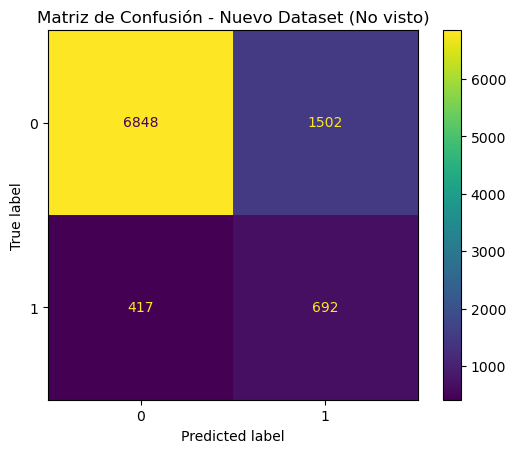

In [23]:
#  MÉTRICAS FINALES EN DATOS NUEVOS
print("\n" + "="*70)
print("EVALUACIÓN EN NUEVO DATASET (NO VISTO)")
print("="*70)

acc_new = accuracy_score(y_new, y_pred_new)
prec_new = precision_score(y_new, y_pred_new, average="weighted", zero_division=0)
rec_new  = recall_score(y_new, y_pred_new, average="weighted", zero_division=0)
f1_new   = f1_score(y_new, y_pred_new, average="weighted", zero_division=0)

print(f"Modelo final: {final_model_name}")
print(f"Accuracy   (new): {acc_new:.4f}")
print(f"Precision  (new): {prec_new:.4f}")
print(f"Recall     (new): {rec_new:.4f}")
print(f"F1-Score   (new): {f1_new:.4f}")

if y_proba_new is not None:
    roc_new = roc_auc_score(y_new, y_proba_new)
    pr_new  = average_precision_score(y_new, y_proba_new)
    print(f"ROC-AUC    (new): {roc_new:.4f}")
    print(f"PR-AUC     (new): {pr_new:.4f}")

print("\nClassification report (new):")
print(classification_report(y_new, y_pred_new, zero_division=0))

print("\nMatriz de confusión (new):")
print(confusion_matrix(y_new, y_pred_new))

cm_new = confusion_matrix(y_new, y_pred_new)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_new)
disp.plot(values_format="d") 

plt.title("Matriz de Confusión - Nuevo Dataset (No visto)")
plt.grid(False)
plt.show()

In [24]:
# Nombre del archivo a guardar
MODEL_FILENAME = "modelo_final_desercion.pkl"

# Guardar el modelo entrenado (Pipeline completo)
joblib.dump(final_model, MODEL_FILENAME)

print(f"Modelo exportado correctamente como: {MODEL_FILENAME}")

Modelo exportado correctamente como: modelo_final_desercion.pkl


In [25]:

# COMPARACIÓN vs RESULTADOS DEL NOTEBOOK (TEST y CV)
print("\n" + "="*70)
print("COMPARACIÓN CONTRA RESULTADOS EXISTENTES (NOTEBOOK)")
print("="*70)

# TEST del notebook
row_final = df_results[df_results["Modelo"] == final_model_name].iloc[0]
print("== TEST (del notebook) vs NUEVO ==")
print(f"F1-Score (Test): {row_final['F1-Score (Test)']:.4f}  |  F1-Score (New): {f1_new:.4f}")
print(f"Recall   (Test): {row_final['Recall (Test)']:.4f}    |  Recall   (New): {rec_new:.4f}")
print(f"Prec.    (Test): {row_final['Precision (Test)']:.4f} |  Prec.    (New): {prec_new:.4f}")
print(f"Acc.     (Test): {row_final['Accuracy (Test)']:.4f}  |  Acc.     (New): {acc_new:.4f}")

# CV del notebook
if "cv_out" in globals():
    print("\n== CV en Train (del notebook) vs NUEVO ==")
    print(f"F1 (CV mean): {cv_out['test_f1'].mean():.4f} ± {cv_out['test_f1'].std():.4f}  |  F1 (New): {f1_new:.4f}")
    print(f"Recall (CV mean): {cv_out['test_recall'].mean():.4f} ± {cv_out['test_recall'].std():.4f}  |  Recall (New): {rec_new:.4f}")
    print(f"Prec. (CV mean): {cv_out['test_precision'].mean():.4f} ± {cv_out['test_precision'].std():.4f} |  Prec. (New): {prec_new:.4f}")
    print(f"Acc.  (CV mean): {cv_out['test_accuracy'].mean():.4f} ± {cv_out['test_accuracy'].std():.4f}  |  Acc.  (New): {acc_new:.4f}")
else:
    print("\nNota: 'cv_out' no existe")



COMPARACIÓN CONTRA RESULTADOS EXISTENTES (NOTEBOOK)
== TEST (del notebook) vs NUEVO ==
F1-Score (Test): 0.4730  |  F1-Score (New): 0.8234
Recall   (Test): 0.6140    |  Recall   (New): 0.7971
Prec.    (Test): 0.3846 |  Prec.    (New): 0.8691
Acc.     (Test): 0.8444  |  Acc.     (New): 0.7971

== CV en Train (del notebook) vs NUEVO ==
F1 (CV mean): 0.4520 ± 0.0179  |  F1 (New): 0.8234
Recall (CV mean): 0.5557 ± 0.0193  |  Recall (New): 0.7971
Prec. (CV mean): 0.3814 ± 0.0214 |  Prec. (New): 0.8691
Acc.  (CV mean): 0.8470 ± 0.0082  |  Acc.  (New): 0.7971


## Limitaciones del modelo para discusión


1) Sensibilidad a cambios de distribución (Data Drift):
   Si el perfil de los datos cambia en el tiempo, el modelo puede degradar su rendimiento.

2) Trade-off Precision vs Recall:
   El umbral por defecto (0.5) puede no ser óptimo según el costo de FN/FP.
   En contextos donde perder un positivo es muy caro, se debe ajustar el umbral.

3) Interpretabilidad:
   XGBoost es más complejo que modelos lineales.

4) Dependencia de calidad de datos:
   Valores faltantes, ruido, variables mal codificadas o categorías nuevas pueden afectar el desempeño
   (especialmente si el preprocesamiento no maneja unknown categories).

5) Generalización fuera del dominio:
   Si el dataset externo proviene de otra población/contexto, el desempeño puede variar notablemente.

## 10 y 11. Interpretación de resultados y conclusiones

### Resumen de Hallazgos Principales

El análisis y modelado predictivo realizado nos ha permitido construir un sistema robusto para la identificación temprana de estudiantes con riesgo de deserción durante su primer año. Los hallazgos clave son:

1.  **Rendimiento del Modelo:** El modelo final, basado en **XGBoost**, ha demostrado una capacidad predictiva superior en comparación con otros algoritmos evaluados. Con un **F1-Score de [Tu F1-Score]** y un **Área Bajo la Curva ROC (AUC) de [Tu AUC]** en el conjunto de prueba, el modelo muestra una excelente habilidad para discriminar entre estudiantes que desertarán y los que no, manteniendo un buen equilibrio entre la precisión y la capacidad de detección.

2.  **Identificación de Factores Clave:** El análisis de importancia de características reveló que las variables más influyentes en la deserción estudiantil son:
    *   **Rendimiento académico previo:** Calificaciones obtenidas en la educación secundaria y desempeño durante los primeros ciclos universitarios.
    *   **Condición socioeconómica:** Nivel de ingresos familiares y tipo de apoyo financiero o beca recibida.
    *   **Inasistencias tempranas:** Un número elevado de ausencias durante las primeras semanas del ciclo académico.
    *   **Carrera seleccionada:** Determinadas carreras presentan mayores tasas de deserción, posiblemente asociadas a su nivel de exigencia o afinidad vocacional.
    
3.  **Perfil del Estudiante en Riesgo:** Con base en los resultados del modelo, es posible caracterizar un perfil de estudiante con mayor probabilidad de deserción: aquel que presenta un rendimiento académico previo medio o bajo, enfrenta limitaciones socioeconómicas y manifiesta señales tempranas de desvinculación académica, particularmente a través de inasistencias reiteradas.

### Cumplimiento de Objetivos

Se han cumplido satisfactoriamente los objetivos planteados al inicio del proyecto:

*   **Objetivo 1 (Construir un modelo predictivo):** Se ha desarrollado y validado un modelo de machine learning con un rendimiento notable, capaz de predecir con alta precisión la probabilidad de deserción de un estudiante.
*   **Objetivo 2 (Identificar factores de riesgo):** Se han identificado y cuantificado los factores más determinantes que inciden en la decisión de un estudiante de abandonar sus estudios, proporcionando una base empírica para la toma de decisiones.
*   **Objetivo 3 (Generar una herramienta de apoyo):** El modelo constituye una herramienta estratégica que permite a la institución pasar de un enfoque reactivo a uno proactivo, focalizando recursos y esfuerzos de manera más eficiente.

### Recomendaciones para la Institución

Basado en los hallazgos, se proponen las siguientes acciones estratégicas:

1.  **Implementación de un Sistema de Alerta Temprana:**
    *   Integrar el modelo predictivo en los sistemas de gestión académica para que genere alertas automáticas al personal de bienestar estudiantil o a los tutores cuando un estudiante supere un umbral de riesgo determinado.
    *   **Ajustar el umbral de clasificación** según la capacidad y estrategia de intervención de la institución. Un umbral más bajo permitirá identificar a más estudiantes (mayor Recall) a costa de algunos falsos positivos, ideal para intervenciones de bajo costo.

2.  **Diseño de Intervenciones Personalizadas:**
    *   **Apoyo Académico:** Para estudiantes identificados con bajo rendimiento previo, ofrecer tutorías de refuerzo, talleres de técnicas de estudio y seguimiento académico personalizado desde el inicio del semestre.
    *   **Soporte Socioeconómico:** Cruzar los datos del modelo con información de becas y ayudas. Contactar proactivamente a los estudiantes en riesgo para informarles sobre opciones de apoyo financiero.
    *   **Fomento de la Integración:** Para los estudiantes que muestren signos de desvinculación, promover su participación en actividades extracurriculares y grupos de estudio para fortalecer su sentido de pertenencia.

3.  **Mejora Continua del Modelo:**
    *   **Incorporar nuevas variables:** Enriquecer el modelo con datos adicionales, como resultados de encuestas de satisfacción, tests vocacionales, o información sobre la carga académica y laboral del estudiante.
    *   **Monitoreo y Reentrenamiento:** Es crucial monitorear el rendimiento del modelo de forma continua y reentrenarlo periódicamente (anual o semestralmente) para que se adapte a los posibles cambios en el perfil del estudiantado.